In [1]:
%matplotlib inline

In [2]:
# %run notebook_setup

/home/tom/anaconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


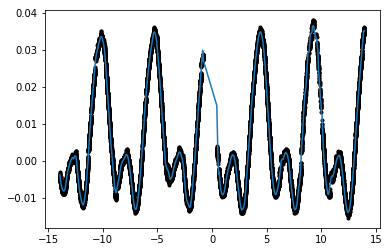

In [3]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

lc_url = "https://archive.stsci.edu/missions/tess/tid/s0001/0000/0004/4142/0236/tess2018206045859-s0001-0000000441420236-0120-s_lc.fits"
with fits.open(lc_url) as hdus:
    lc = hdus[1].data
    lc_hdr = hdus[1].header

texp = lc_hdr["FRAMETIM"] * lc_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
time = lc["TIME"]
flux = lc["PDCSAP_FLUX"]
flux_err = lc["PDCSAP_FLUX_ERR"]
m = np.isfinite(time) & np.isfinite(flux) & (lc["QUALITY"] == 0)
time = time[m]
flux = flux[m]
flux_err = flux_err[m]

# Identify outliers
m = np.ones(len(flux), dtype=bool)
for i in range(10):
    y_prime = np.interp(time, time[m], flux[m])
    smooth = savgol_filter(y_prime, 301, polyorder=3)
    resid = flux - smooth
    sigma = np.sqrt(np.mean(resid**2))
    m0 = resid < sigma
    if m.sum() == m0.sum():
        m = m0
        break
    m = m0

# Just for this demo, subsample the data
ref_time = 0.5 * (np.min(time[m])+np.max(time[m]))
time = np.ascontiguousarray(time[m] - ref_time, dtype=np.float64)
flux = np.ascontiguousarray(flux[m], dtype=np.float64)
flux_err = np.ascontiguousarray(flux_err[m], dtype=np.float64)

mu = np.median(flux)
flux = flux / mu - 1
flux_err /= mu

x = time
y = flux * 1000
yerr = flux_err * 1000

plt.plot(time, flux, ".k")
plt.plot(time, smooth[m] / mu - 1);

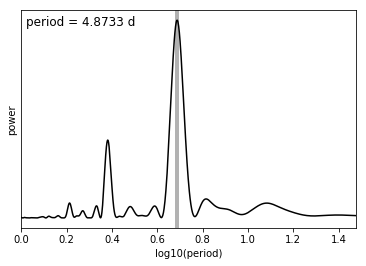

In [4]:
import exoplanet as xo

results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=1, min_period=1.0, max_period=30.0,
    samples_per_peak=50)

peak = results["peaks"][0]
ls_period = peak["period"]
freq, power = results["periodogram"]
plt.plot(-np.log10(freq), power, "k")
plt.axvline(np.log10(ls_period), color="k", lw=4, alpha=0.3)
plt.xlim((-np.log10(freq)).min(), (-np.log10(freq)).max())
plt.annotate("period = {0:.4f} d".format(ls_period),
             (0, 1), xycoords="axes fraction",
             xytext=(5, -5), textcoords="offset points",
             va="top", ha="left", fontsize=12)
plt.yticks([])
plt.xlabel("log10(period)")
plt.ylabel("power");

In [19]:
import pymc3 as pm
import theano.tensor as tt

def build_model(mask=None):
    guess_p_period = 16.93, 30.537
    guess_p_t0 = -8.84, 2.99
    guess_p_depth = 0.05, 0.02
    if mask is None:
        mask = np.ones_like(x, dtype=bool)
    with pm.Model() as model:

        # The mean flux of the time series
        mean = pm.Normal("mean", mu=6, sd=10.0)

        # A jitter term describing excess white noise
        logs2 = pm.Normal("logs2", mu=2*np.log(np.min(yerr[mask])), sd=5.0)

        # A SHO term to capture long term trends
        logS = pm.Normal("logS", mu=0.0, sd=15.0, testval=np.log(np.var(y[mask])))
        logw = pm.Normal("logw", mu=np.log(2*np.pi/10.0), sd=10.0)
        term1 = xo.gp.terms.SHOTerm(log_S0=logS, log_w0=logw, Q=1/np.sqrt(2))
        
        # The parameters of the RotationTerm kernel
        logamp = pm.Normal("logamp", mu=np.log(np.var(y[mask])), sd=5.0)
        logperiod = pm.Normal("logperiod", mu=np.log(ls_period), sd=5.0)
        period = pm.Deterministic("period", tt.exp(logperiod))
        logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
        logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
        mix = pm.Uniform("mix", lower=0, upper=1.0)
        term2 = xo.gp.terms.RotationTerm(
            log_amp=logamp,
            period=period,
            log_Q0=logQ0,
            log_deltaQ=logdeltaQ,
            mix=mix
        )

        u_star = xo.distributions.QuadLimbDark("u_star",
                                              testval=np.array([0.3, 0.2]))
        R_star = 0.8, 0.1
        Rho_star = 0.8
        r_star = pm.Normal("r_star", mu=R_star[0], sd=R_star[1])
        logrho_star = pm.Normal("logrho_star", mu=np.log(Rho_star), sd=1)
        rho_star = pm.Deterministic("rho_star", tt.exp(logrho_star))
        pm.Potential("r_star_prior", tt.switch(r_star > 0, 0, -np.inf))
        logP = pm.Normal("logP", mu=np.log(guess_p_period), sd=0.003, shape=2)
        t0 = pm.StudentT("t0", mu=guess_p_t0, nu=1.0, sd=0.2, shape=2)
#         ror, b = xo.distributions.get_joint_radius_impact(
#             min_radius=0.001, max_radius=0.3,
#             testval_r=p_depth,
#             testval_b=0.1)
        logror = pm.Normal("logror", mu=np.log(guess_p_depth),
                           sd=2, shape=2)
        ror = pm.Deterministic("r", tt.exp(logror))
        b_param = pm.Uniform("b_param", lower=0, upper=1, shape=2, testval=[0.3, 0.6])
        b = pm.Deterministic("b", b_param * (1 + ror))
        ecc = pm.Bound(pm.Beta, lower=0.0, upper=1.0)("ecc", alpha=0.867, beta=3.03, testval=0.05,
                                                     shape=2)
        omega = xo.distributions.Angle("omega", shape=2)

        
        pm.Potential("ror_prior_lo", tt.switch(tt.all(0.005 < ror), 0.0, -np.inf))
        pm.Potential("ror_prior_hi", tt.switch(tt.all(ror < 0.3), 0.0, -np.inf))  
#         pm.Potential("ror_prior", -tt.log(ror))

    #         pm.Potential("b_prior",  tt.switch(b < 1, 0, -np.inf))
        p_period = pm.Deterministic("p_period", tt.exp(logP))
        r_pl = pm.Deterministic("r_pl", r_star * ror)
        r_ple = pm.Deterministic("r_ple", r_star * ror / 0.009155)
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, #m_star=m_star,
            period=p_period, t0=t0, b=b,
            rho_star=rho_star, ecc=ecc, omega=omega)
        light_curves = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1)
        pm.Deterministic("light_curves", light_curves)

        # Set up the Gaussian Process model
        kernel = term1 + term2
        gp = xo.gp.GP(kernel, x[mask], yerr[mask]**2 + tt.exp(logs2), J=6)

        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        pm.Potential("loglike", gp.log_likelihood(y[mask] - mean - light_curve))

        # Compute the mean model prediction for plotting purposes
        pm.Deterministic("pred", gp.predict())

        # Optimize to find the maximum a posteriori parameters
        map_soln = pm.find_MAP(start=model.test_point, vars=[mean, logs2])
        map_soln = pm.find_MAP(start=map_soln, vars=[mean, logs2, logS, logw])
        map_soln = pm.find_MAP(start=map_soln, vars=[mean, logs2, logamp, logQ0, logdeltaQ, mix])
        map_soln = pm.find_MAP(start=map_soln, vars=[model.logror, model.b_param])
        map_soln = pm.find_MAP(start=map_soln, vars=[model.logror, model.b_param, logP, t0])
        
    return model, map_soln

model0, map_soln0 = build_model()

/home/tom/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -10,152, ||grad|| = 2,346.5: 100%|██████████| 7/7 [00:00<00:00, 66.80it/s]   
logp = -7,848.9, ||grad|| = 0.028458: 100%|██████████| 53/53 [00:01<00:00, 52.07it/s]  
logp = -7,825.8, ||grad|| = 0.

In [20]:
map_soln0

{'mean': array(6.61773602),
 'logs2': array(-2.70360721),
 'logS': array(-6.39769344),
 'logw': array(4.4917075),
 'logamp': array(5.02111503),
 'logperiod': array(1.58376437),
 'logQ0': array(0.73750861),
 'logdeltaQ': array(8.48324018),
 'mix_interval__': array(-1.13863723),
 'u_star_quadlimbdark__': array([-1.09861229, -0.84729786]),
 'r_star': array(0.8),
 'logrho_star': array(-0.22314355),
 'logP': array([2.82725543, 3.41894788]),
 't0': array([-8.84145235,  2.99045276]),
 'logror': array([-3.39048437, -3.82014556]),
 'b_param_interval__': array([-0.76844788,  0.35716143]),
 'ecc_interval__': array([-2.94443898, -2.94443898]),
 'omega_angle__': array([[0., 0.],
        [1., 1.]]),
 'period': array(4.87326608),
 'mix': array(0.24257066),
 'u_star': array([0.3, 0.2]),
 'rho_star': array(0.8),
 'r': array([0.03369235, 0.02192461]),
 'b_param': array([0.31681496, 0.58835312]),
 'b': array([0.3274892 , 0.60125254]),
 'ecc': array([0.05, 0.05]),
 'omega': array([1.57079633, 1.57079633])

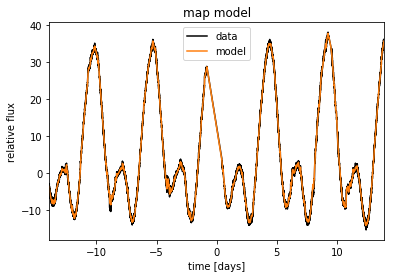

In [21]:
plt.plot(x, y, "k", label="data")
plt.plot(x, map_soln0["pred"] + map_soln0["mean"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux")
plt.title("map model");

(-9.5, -8)

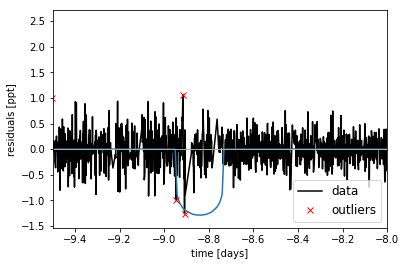

In [22]:
mod = map_soln0["pred"] + map_soln0["mean"] + np.sum(map_soln0["light_curves"], axis=-1)
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 5. * rms

plt.plot(x, resid, "k", label="data")
plt.plot(x, np.sum(map_soln0["light_curves"], axis=-1))
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=4)
plt.xlim(x.min(), x.max());
plt.xlim(-9.5,-8)

In [23]:
model, map_soln = build_model(mask)

/home/tom/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -9,114.1, ||grad|| = 1,852.9: 100%|██████████| 7/7 [00:00<00:00, 68.19it/s]   
logp = -7,106.5, ||grad|| = 3.3884: 100%|██████████| 48/48 [00:00<00:00, 53.24it/s]  
logp = -7,082.6, ||grad|| = 0.0

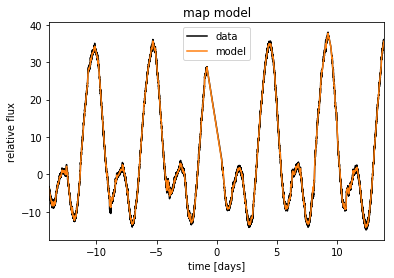

In [24]:
plt.plot(x[mask], y[mask], "k", label="data")
plt.plot(x[mask], map_soln["pred"] + map_soln["mean"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux")
plt.title("map model");

(11, 13)

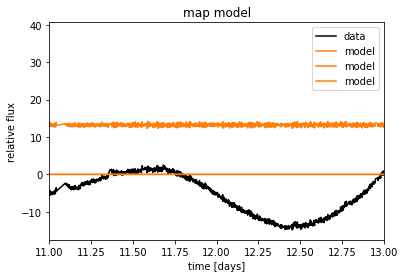

In [25]:
plt.plot(x[mask], y[mask], "k", label="data")
plt.plot(x[mask], y[mask] - map_soln["pred"] + map_soln["mean"], color="C1", label="model")
plt.plot(x[mask], map_soln["light_curves"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux")
plt.title("map model");

plt.xlim(-10,-8)
plt.xlim(11,13)
# plt.ylim(-0.2,0.25)

In [26]:
sampler = xo.PyMC3Sampler(window=200, start=100, finish=200)
with model:
    sampler.tune(tune=2000, start=map_soln, step_kwargs=dict(target_accept=0.9))

/home/tom/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sampling 4 chains: 100%|██████████| 808/808 [18:39<00:00,  1.45s/draws]
The chain contains only diverging samples. The model is probably misspecified.
The chain contains only diverging samples. The model is probably misspecified.
Sampling 4 chains:  46%|████▌     | 737/1608 [17:07<26:03,  1.80s/draws]


ValueError: Not enough samples to build a trace.

In [ ]:
with model:
    trace = sampler.sample(draws=3000)

In [ ]:
period_samples = trace["period"]
plt.hist(period_samples, 35, histtype="step", color="k")
plt.yticks([])
plt.xlabel("rotation period [days]")
plt.ylabel("posterior density");
plt.tight_layout()
plt.savefig('rotation-posterior.png', dpi=200)

In [ ]:
period_samples = trace["p_period"]
plt.hist(period_samples, 35, histtype="step", )
plt.yticks([])
plt.xlabel("orbital period [days]")
plt.ylabel("posterior density");

In [30]:
map_soln

{'mean': array(6.60330608),
 'logs2': array(-2.85161561),
 'logS': array(-6.56365113),
 'logw': array(4.52639503),
 'logamp': array(5.02222976),
 'logperiod': array(1.58376437),
 'logQ0': array(0.3987485),
 'logdeltaQ': array(8.32488635),
 'mix_interval__': array(-1.15021827),
 'u_star_quadlimbdark__': array([-1.09861229, -0.84729786]),
 'r_star': array(0.8),
 'logrho_star': array(-0.22314355),
 'logP': array([2.8309761 , 3.35671777]),
 't0': array([-8.85785118,  2.89257582]),
 'logror': array([-3.16059266, -4.20176925]),
 'b_param_interval__': array([0.22515909, 0.39284627]),
 'ecc_interval__': array([-2.94443898, -2.94443898]),
 'omega_angle__': array([[0., 0.],
        [1., 1.]]),
 'period': array(4.87326608),
 'mix': array(0.24044922),
 'u_star': array([0.3, 0.2]),
 'rho_star': array(0.8),
 'r': array([0.0424006 , 0.01496907]),
 'b_param': array([0.55605316, 0.59696769]),
 'b': array([0.57963016, 0.60590374]),
 'ecc': array([0.05, 0.05]),
 'omega': array([1.57079633, 1.57079633]),


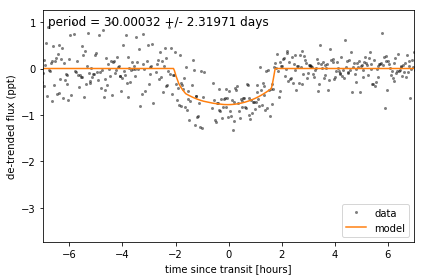

In [31]:
# Compute the GP prediction
gp_mod = np.median(trace["pred"] + trace["mean"][:, None], axis=0)

# Get the posterior median orbital parameters
p = np.median(trace["p_period"][:,1])
t0 = np.median(trace['t0'][:,1])

# Plot the folded data
x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
plt.plot(x_fold * 24., y[mask] - gp_mod, ".k", label="data",
         alpha=0.5, zorder=-1000, mec="none")

# # Overplot the phase binned light curve
# bins = np.linspace(-10, 10, 50)
# denom, _ = np.histogram(x_fold, bins)
# num, _ = np.histogram(x_fold, bins, weights=y[mask])
# denom[num == 0] = 1.0
# plt.plot(0.5*(bins[1:] + bins[:-1]) *  24., num / denom, "o", color="C2",
#          label="binned")

# Plot the folded model
inds = np.argsort(x_fold)
inds = inds[np.abs(x_fold)[inds] < 0.3]
pred = trace["light_curves"][:, inds, 1]
pred = np.percentile(pred, [16, 50, 84], axis=0)
plt.plot(x_fold[inds] * 24., pred[1], color="C1", label="model")
# art = plt.fill_between(x_fold[inds] * 24., pred[0], pred[2], color="C1", alpha=0.3,
#                        zorder=1000)
# art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.5f} +/- {1:.5f} days".format(
    np.mean(trace["p_period"][:,1]), np.std(trace["p_period"][:,1]))

plt.annotate(txt, (0, 0.9), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom", fontsize=12)

# plt.annotate('AU Mic b', (0, 1), xycoords="axes fraction",
#              xytext=(5, 5), textcoords="offset points",
#              ha="left", va="bottom", fontsize=12)

plt.legend(fontsize=10, loc=4)
plt.xlabel("time since transit [hours]")
plt.ylabel("de-trended flux (ppt)")
plt.xlim(-7, 7);

plt.tight_layout()
plt.savefig('transit-plot-2.png', dpi=200)

In [32]:
pred = np.percentile(trace["light_curves"][:, :, 0] + 
    trace["light_curves"][:, :, 1] + trace["mean"][:, None] +
                     trace["pred"], [5,50,95], axis=0)
pred1 = np.percentile(trace["light_curves"][:, :, 0] + 
    trace["light_curves"][:, :, 1], [5,50,95], axis=0)
pred2 = np.percentile(trace["pred"] + trace["mean"][:, None], [5,50,95], axis=0)

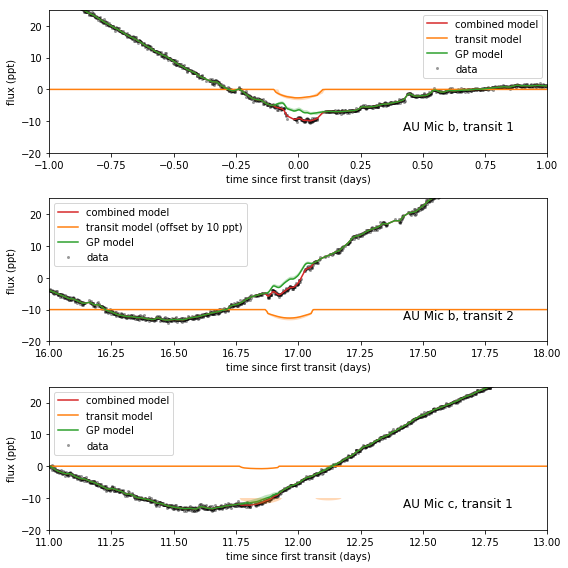

In [36]:
fig,  [ax1, ax2, ax3] = plt.subplots(3,1, figsize=[8, 8])
time = x[mask] - np.median(trace['t0'][:,0])

ax1.plot(time, pred[1], color='C3', label = 'combined model')
art = ax1.fill_between(time, pred[0], pred[2], color="C3", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax1.plot(time, pred1[1], color='C1', label = 'transit model')
art = ax1.fill_between(time, pred1[0], pred1[2], color="C1", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax1.plot(time, pred2[1], color='C2', label = 'GP model')
art = ax1.fill_between(time, pred2[0], pred2[2], color="C2", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax1.plot(time, y[mask], ".k", label="data",
         alpha=0.4, zorder=-1000, mec="none")

ax1.set_xlim(-1,1)
ax1.set_ylim(-20, 25)

ax1.legend()
ax1.set_xlabel("time since first transit (days)")
ax1.set_ylabel("flux (ppt)")

ax1.annotate('AU Mic b, transit 1', (0.7, 0.1), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom", fontsize=12)

ax2.plot(time, pred[1], color='C3', label = 'combined model')
art = ax2.fill_between(time, pred[0], pred[2], color="C3", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax2.plot(time, pred1[1] -10, color='C1', label = 'transit model (offset by 10 ppt)')
art = ax2.fill_between(time, pred1[0] -10, pred1[2]-10, color="C1", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax2.plot(time, pred2[1], color='C2', label = 'GP model')
art = ax2.fill_between(time, pred2[0], pred2[2], color="C2", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax2.plot(time, y[mask], ".k", label="data",
         alpha=0.4, zorder=-1000, mec="none")

ax2.set_xlim(16,18)
ax2.set_ylim(-20, 25)
ax2.legend()
ax2.set_xlabel("time since first transit (days)")
ax2.set_ylabel("flux (ppt)")

ax2.annotate('AU Mic b, transit 2', (0.7, 0.1), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom", fontsize=12)

ax3.plot(time, pred[1], color='C3', label = 'combined model')
art = ax3.fill_between(time, pred[0], pred[2], color="C3", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax3.plot(time, pred1[1] , color='C1', label = 'transit model')
art = ax3.fill_between(time, pred1[0] -10, pred1[2]-10, color="C1", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax3.plot(time, pred2[1], color='C2', label = 'GP model')
art = ax3.fill_between(time, pred2[0], pred2[2], color="C2", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax3.plot(time, y[mask], ".k", label="data",
         alpha=0.4, zorder=-1000, mec="none")

ax3.set_xlim(11, 13)
ax3.set_ylim(-20, 25)
ax3.legend()
ax3.set_xlabel("time since first transit (days)")
ax3.set_ylabel("flux (ppt)")

ax3.annotate('AU Mic c, transit 1', (0.7, 0.1), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom", fontsize=12)

plt.tight_layout()
plt.savefig('transits-GP-v2.png', dpi=200)

NameError: name 'mask' is not defined

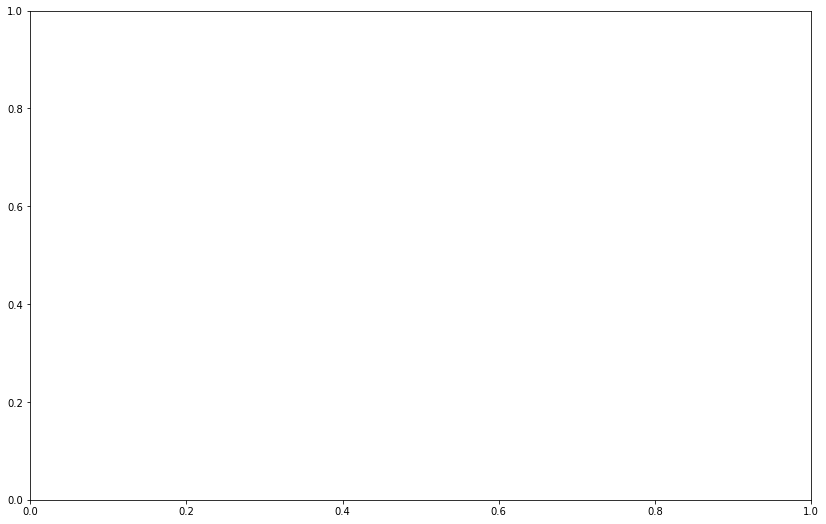

In [8]:
fig,  ax = plt.subplots(1,1, figsize=[14, 9])
plt.plot(x[mask], gp_mod, color="C3", label="model")
plt.plot(x[mask], np.percentile(pred, [50], axis=0)[0] + gp_mod, color="C2", label="model")
plt.plot(x[mask], np.percentile(pred, [50], axis=0)[0], color="C1", label="model")
plt.scatter(x,y, s=1)
plt.xlim(-1,3)

In [38]:
pm.summary(trace, varnames=["logw", "logS", "logs2", "logamp", "r_ple", "logperiod", "logQ0",
                            "b", "t0", "p_period", "r_star", "rho_star", "u_star", "mean", 'logror', 'r', 'logrho_star',
                           'logrho_star'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logw,4.233877,0.029911,0.002909,4.211265,4.308205,NaN,1.663545
logS,-5.720406,0.100026,0.009812,-5.937426,-5.637551,2.583196,2.409398
logs2,-2.836535,0.010501,0.001024,-2.845255,-2.809546,NaN,1.674807
logamp,4.624962,0.219576,0.020727,4.262221,4.992861,NaN,1.158132
r_ple__0,3.692127,0.392146,0.038870,3.142041,4.402244,3.205591,1.826822
r_ple__1,2.255622,0.832253,0.083017,0.568229,2.962983,2.098955,5.456816
logperiod,1.578351,0.005155,0.000510,1.573403,1.585506,NaN,4.244662
logQ0,2.009592,0.480190,0.047545,1.588545,2.769128,2.132409,4.593272
b__0,0.217029,0.121146,0.011949,0.076549,0.376097,NaN,3.783151
b__1,0.543667,0.186240,0.018278,0.180250,0.852528,6.073150,1.438527


In [266]:
x[mask] - np.median(trace['t0'])

array([-5.08855398, -5.08716509, -5.0857762 , ..., 22.77342696,
       22.77481579, 22.77620463])

In [165]:
import pickle
with open('my_model.pkl', 'wb') as buff:
    pickle.dump({'model': model, 'trace': trace}, buff)

In [168]:
del map_soln0

(8000, 17242)

In [13]:
np.exp(np.log(0.5)+2)

3.6945280494653248

In [37]:
with model:
    trace = sampler.sample(draws=4)

Only 4 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega, ecc, b_param, logror, t0, logP, logrho_star, r_star, u_star, mix, logdeltaQ, logQ0, logperiod, logamp, logw, logS, logs2, mean]
/home/tom/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sampling 4 chains: 100%|██████████| 4016/4016 [5:18:38<00:00,  9.56s/draws]  
/home/tom/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:476: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
The chain reached the maximum tree depth. Increase max_treedepth, increase target

In [46]:
trace['t0'][:,0]

array([-8.83951317, -8.84183329, -8.83966123, ..., -8.84034143,
       -8.84009658, -8.84021215])

(-0.02, 0)

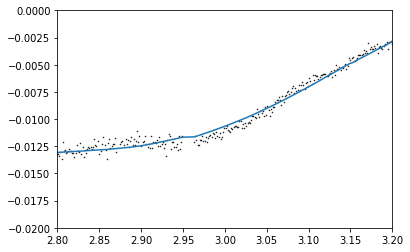

In [16]:
plt.plot(time, flux, ".k", ms=1)
plt.plot(time, smooth[m] / mu - 1);
plt.xlim(2.8, 3.2)
plt.ylim(-0.02,0)

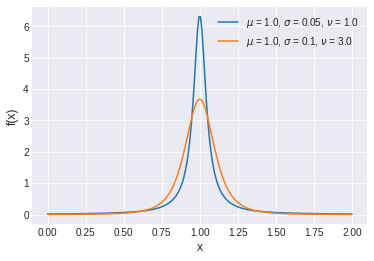

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
plt.style.use('seaborn-darkgrid')
x = np.linspace(0, 2, 200)
mus = [1., 1.,] 
sigmas = [0.05, 0.1, ]
dfs = [1., 3.,]
for mu, sigma, df in zip(mus, sigmas, dfs):
    pdf = st.t.pdf(x, df, loc=mu, scale=sigma)
    plt.plot(x, pdf, label=r'$\mu$ = {}, $\sigma$ = {}, $\nu$ = {}'.format(mu, sigma, df))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)

In [18]:
2458342.226 - 2457000 - ref_time

2.990807203299937